In [93]:
import logging
import sys

import torch
import torch.nn as nn
from torch.distributions import constraints

import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceTMC_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.ops.indexing import Vindex
from pyro.optim import Adam
from pyro.util import ignore_jit_warnings

import visualization as V

%load_ext autoreload
%autoreload 2

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.DEBUG)

log = logging.getLogger()
debug_handler = logging.StreamHandler(sys.stdout)
debug_handler.setLevel(logging.DEBUG)
debug_handler.addFilter(filter=lambda record: record.levelno <= logging.DEBUG)
log.addHandler(debug_handler)


cuda = True
num_steps = 10
learning_rate = .05
tmc_num_samples = 100
seed = 0
batch_size = 16
hidden_dim = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
def HMM(data=None, shape=None, hidden_dim=None, batch_size=None, include_prior=True, jit=True):
    if shape is not None:
        max_length, num_sequences, data_dim = map(int, shape)
    else:
        max_length, num_sequences, data_dim = map(int, data.shape)

    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([hidden_dim, data_dim]).to_event(2))
#         probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        x = 0
        for t in pyro.markov(range(max_length)):
            x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
            X.append(x.squeeze())
            with obs_plate:
#                     y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x.squeeze(-1)]))
                if data is None:
                    y = pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0))
                else:
                    y = pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0),obs=data[t,batch])
                Y.append(y)
    return torch.stack(X), torch.stack(Y), probs_x, probs_y

def ARHMM(data=None, shape=None, hidden_dim=None, batch_size=None, include_prior=True, jit=True):
    if shape is not None:
        max_length, num_sequences, data_dim = map(int, shape)
    else:
        max_length, num_sequences, data_dim = map(int, data.shape)
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([hidden_dim, data_dim]).to_event(2))
#         probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, 2, data_dim]).to_event(3))
    
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        x, y = 0, 0
        for t in pyro.markov(range(max_length)):
            x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
            X.append(x.squeeze())
            with obs_plate as obs:
                if data is None:
                    y = pyro.sample("y_{}".format(t),dist.Normal(.9*y + probs_y[x.squeeze(-1)],1.0))
#                     y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x, y, obs])).long()
                else:
                    y = pyro.sample("y_{}".format(t),dist.Normal(.9*y + probs_y[x.squeeze(-1)],1.0),obs=data[t,batch])
                Y.append(y)

    return torch.stack(X), torch.stack(Y), probs_x, probs_y

torch.Size([500, 1, 3])


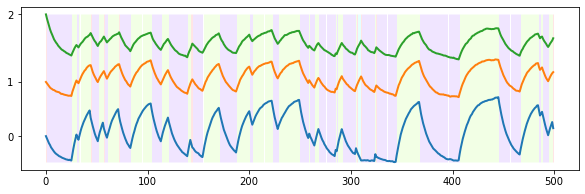

In [144]:
X, Y, probs_x, probs_y = ARHMM(shape=[500,1,3], hidden_dim=4)
print(Y.shape)
V.plot_signals(Y[:,0,:].cpu(),z=X.cpu().squeeze())

In [145]:
print(X.shape)
print(Y.shape)

torch.Size([500])
torch.Size([500, 1, 3])


In [146]:
pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = AutoDelta(poutine.block(ARHMM, expose_fn=lambda msg: msg["name"].startswith("probs_")))

optim = Adam({"lr": .5})
elbo = TraceTMC_ELBO(max_plate_nesting=2)
tmc_model = poutine.infer_config(ARHMM,
    lambda msg: {"num_samples": tmc_num_samples, "expand": False} if msg["infer"].get("enumerate", None) == "parallel" else {},
)
svi = SVI(tmc_model, guide, optim, elbo)

losses = []

for step in range(num_steps):
    loss = svi.step(data=Y, hidden_dim=hidden_dim, batch_size=1)
    losses.append(loss)
    logging.info("{: >5d}\t{}".format(step, loss))


  3782507     0	90841.859375
  3784883     1	83645.03125
  3787213     2	76793.7578125
  3789913     3	70328.0546875
  3792440     4	64237.54296875
  3794706     5	58556.20703125
  3797056     6	53252.1875
  3799290     7	48293.2421875
  3801371     8	43687.96484375
  3803677     9	39405.0390625


  4017792 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017795 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017807 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017813 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017817 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017823 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4017924 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017928 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017936 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017940 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017947 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017950 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4017967 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017970 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017975 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017980 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4017984 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4017988 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4017999 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018001 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018007 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018012 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018018 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018022 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018043 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018047 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018052 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018055 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018063 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018066 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018077 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018081 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018087 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018090 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018096 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018099 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018120 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018125 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018132 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018135 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018142 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018146 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018155 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018160 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018165 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018168 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018176 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018180 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018208 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018212 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018219 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018222 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018230 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018234 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

  4018295 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018299 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018305 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018310 ticklocs array([   1000.,   10000.,  100000., 1000000.])


ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])
ticklocs array([   1000.,   10000.,  100000., 1000000.])


  4018314 vmin 37793.32043656828 vmax 94715.86449224537


vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537
vmin 37793.32043656828 vmax 94715.86449224537


  4018317 ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])


ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
ticklocs array([2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04,

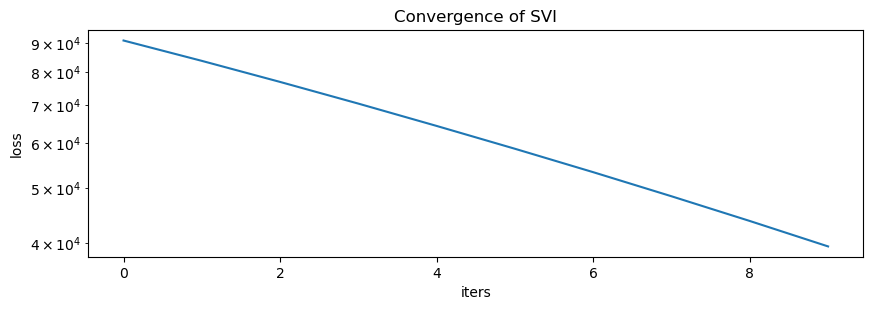

NameError: name 'title' is not defined

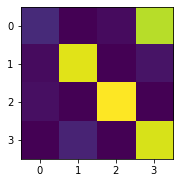

In [149]:
map_estimates = guide(Y)

V.plot_loss(losses)
V.plot_transition([probs_x.detach().numpy(),map_estimates['probs_x'].detach().numpy()],titles=['True','Inferred'])

print('True centers')
print(probs_y.detach().numpy())

print('Inferred centers')
map_estimates['probs_y'].detach().numpy()